In [1]:
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
from efficientnet_pytorch import EfficientNet

In [3]:
from torchvision import transforms

In [4]:
from sklearn.metrics import roc_auc_score
from collections import Counter

# Load the data

In [5]:
path = Path('../../storage/plant-pathology')
path.ls()

(#5) [Path('../../storage/plant-pathology/images'),Path('../../storage/plant-pathology/sample_submission.csv'),Path('../../storage/plant-pathology/test.csv'),Path('../../storage/plant-pathology/train.csv'),Path('../../storage/plant-pathology/.ipynb_checkpoints')]

In [6]:
Path.BASE_PATH = path
path.ls()

(#5) [Path('images'),Path('sample_submission.csv'),Path('test.csv'),Path('train.csv'),Path('.ipynb_checkpoints')]

In [7]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


### Class Distribution

In [8]:
# dictionary to store labels of individual rows to be latter used 
# for oversampling
idx_labels = {} 

In [9]:
counter = Counter()
for idx, row in df.iterrows():
    label = row.loc[row==1].index[0]
    counter[label] += 1
    idx_labels[idx] = label

In [10]:
counter

Counter({'scab': 592, 'multiple_diseases': 91, 'healthy': 516, 'rust': 622})

**Plot distribution of images in the dataset**

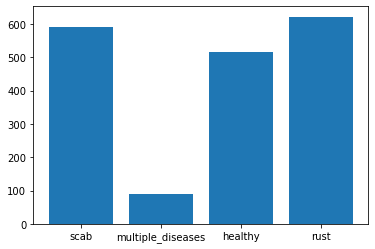

In [11]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

*The dataset is imbalanced so we will oversample from the classes with a low number of samples*

In [12]:
max(counter.values())

622

In [13]:
def oversample(df: pd.DataFrame, cond, limit: int):
    grouped = df.groupby(cond)
    lst = []
    
    for name, group in grouped:
        if len(group) < limit:
            lst.append(group.sample(limit, replace=True))
        else:
            lst.append(group)
    return pd.concat(lst)

In [14]:
df_oversampled = oversample(df, idx_labels, max(counter.values()))

In [15]:
counter = Counter()
for idx, row in df_oversampled.iterrows():
    label = row.loc[row==1].index[0]
    counter[label] += 1

In [16]:
counter

Counter({'healthy': 622, 'multiple_diseases': 622, 'rust': 622, 'scab': 622})

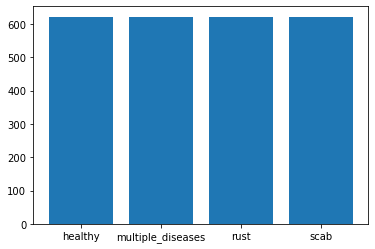

In [17]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

## Create DataLoaders

In [18]:
dblock = DataBlock()

In [19]:
dsets = dblock.datasets(df_oversampled)
dsets.train[0]

(image_id             Train_1333
 healthy                       0
 multiple_diseases             0
 rust                          0
 scab                          1
 Name: 1333, dtype: object,
 image_id             Train_1333
 healthy                       0
 multiple_diseases             0
 rust                          0
 scab                          1
 Name: 1333, dtype: object)

**Define get_x and get_y functions to return the dependent and independent variables in their right formats**
- get_x returns the path to the image
- get_y returns the label(s) as a list because the problem is a multi-category classification problem

In [20]:
def get_x(r): return path/'images'/f'{r["image_id"]}.jpg'
def get_y(r): return r.loc[r==1].index[0]

In [21]:
dblock = DataBlock(get_x=get_x, 
                   get_y=get_y)
dsets = dblock.datasets(df_oversampled)
dsets.train[0]

(Path('images/Train_399.jpg'), 'multiple_diseases')

**Define complete DataBlock**

In [22]:
@Transform
def efficientnet_norm(x: TensorImage):
    return  x * 2.0 - 1.0

In [25]:
def get_dls(size, bs):
    db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(size*2),
                   batch_tfms=aug_transforms(size=size, min_scale=0.75, flip_vert=True))
    return db.dataloaders(df_oversampled, bs=bs)

In [26]:
dls = get_dls(512, 32)

*Appearance of images is due to normalization scheme used, which is the one used for the efficientnet model that will be used to train the model*

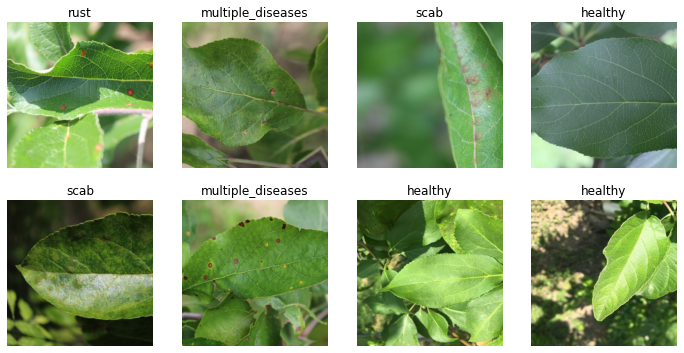

In [25]:
dls.show_batch()

# Define Learner

**Define roc metric**

In [27]:
def roc(preds, targs):
    preds, targs = preds.cpu(), targs.cpu()
    labels = range(dls.c)
    targs = np.eye(dls.c)[targs]
    return np.mean([roc_auc_score(targs[:, i], preds[:, i]) for i in labels])

**Learner**

In [28]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy, AccumMetric(roc, flatten=False)]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.0964781722577754e-06)

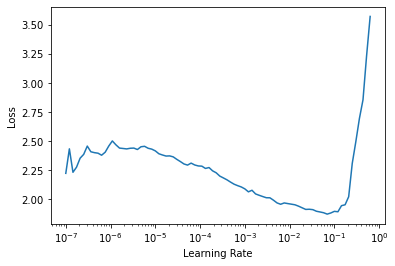

In [29]:
learn.lr_find()

In [30]:
learn.fine_tune(15, 1e-3, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy,roc,time
0,1.748261,0.957752,0.724346,0.895576,01:06
1,1.356899,0.836194,0.847082,0.947615,01:05
2,1.162049,0.788236,0.869215,0.946921,01:05
3,1.044773,0.802014,0.849095,0.954470,01:04
4,0.918049,0.677339,0.877264,0.968434,01:05


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.752273,0.590929,0.945674,0.982133,01:23
1,0.698965,0.576162,0.943662,0.984766,01:22
2,0.690584,0.543248,0.943662,0.987830,01:22
3,0.644990,0.498229,0.961771,0.992708,01:22
4,0.610209,0.548453,0.945674,0.989385,01:22
5,0.578660,0.522623,0.957747,0.991321,01:21
6,0.538858,0.480570,0.963783,0.997497,01:22
7,0.516343,0.450317,0.971831,0.997336,01:21
8,0.494286,0.441788,0.975855,0.998535,01:22
9,0.472582,0.430334,0.975855,0.998855,01:22


In [31]:
learn.save('rn50-512')

In [76]:
learn.load('rn50-512')

## Model Intepretation

In [54]:
interp = ClassificationInterpretation.from_learner(learn)

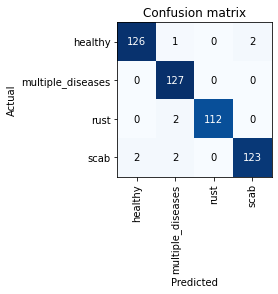

In [55]:
interp.plot_confusion_matrix()

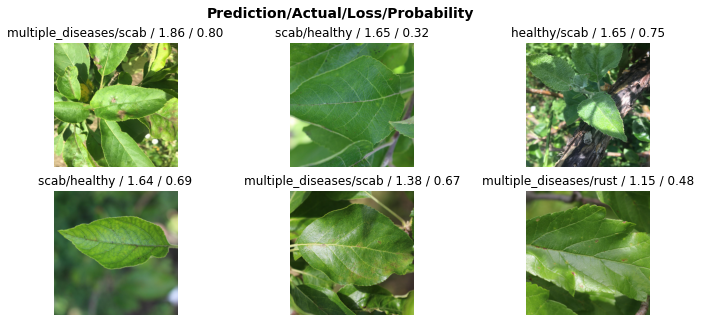

In [34]:
interp.plot_top_losses(6, figsize=(12, 5))

## Increase image sizes

In [48]:
dls = get_dls(1024, 8)

Shape of images before progessive resizing

In [49]:
xb, yb = learn.dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

Apply progressize resizing

In [50]:
learn.dls = dls

In [51]:
xb, yb = learn.dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([8, 3, 1024, 1024]), torch.Size([8]))

## Train for a few epochs on new images

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.3182567499825382e-06)

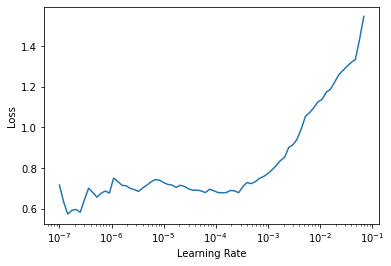

In [52]:
learn.lr_find()

In [53]:
learn.fine_tune(10, 1e-4, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,roc,time
0,0.670007,0.476098,0.961771,0.992698,03:57
1,0.648857,0.474199,0.953722,0.993784,03:56
2,0.621260,0.494275,0.949698,0.992141,03:57


epoch,train_loss,valid_loss,accuracy,roc,time
0,0.616034,0.465860,0.963783,0.995286,05:05
1,0.607383,0.438014,0.977867,0.997264,05:03
2,0.591068,0.457644,0.965795,0.997042,05:04
3,0.543453,0.440104,0.979879,0.997161,05:04
4,0.548346,0.436438,0.971831,0.996942,05:05
5,0.543992,0.442597,0.977867,0.997504,05:08
6,0.540994,0.432286,0.973843,0.997708,05:08
7,0.575724,0.446141,0.975855,0.997851,05:07
8,0.527477,0.442307,0.967807,0.998001,05:05
9,0.544992,0.428904,0.981891,0.997837,05:04


## Evaluate on test set

In [35]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [77]:
test_dl = learn.dls.test_dl(test_df, with_labels=False)

In [78]:
probs_tta, classes_tta = learn.tta(dl=test_dl)

In [84]:
probs, classes = learn.get_preds(dl=test_dl)

In [79]:
probs.shape

torch.Size([1821, 4])

In [85]:
probs[0], probs_tta[0]

(tensor([0.1081, 0.2789, 0.4902, 0.1228]),
 tensor([0.1946, 0.2260, 0.4181, 0.1613]))

In [89]:
probs_tta_df = pd.DataFrame(probs_tta)
probs_df = pd.DataFrame(probs)

In [90]:
probs_df.head()

,0,1,2,3
0,0.108094,0.278905,0.490155,0.122846
1,0.085175,0.098901,0.562506,0.253418
2,0.485944,0.010085,0.057607,0.446363
3,0.952082,0.012733,0.017489,0.017695
4,0.085636,0.062500,0.566655,0.285210


In [91]:
probs_tta_df.head()

,0,1,2,3
0,0.194636,0.225970,0.418090,0.161304
1,0.093832,0.147236,0.468084,0.290848
2,0.416479,0.020513,0.060137,0.502872
3,0.922996,0.013081,0.025703,0.038219
4,0.061873,0.057034,0.553135,0.327958


In [61]:
learn.dls.vocab

(#4) ['healthy','multiple_diseases','rust','scab']

In [62]:
probs_df.columns = learn.dls.vocab

In [67]:
probs_df.iloc[900:510]

,healthy,multiple_diseases,rust,scab


In [68]:
probs_df.head()

,healthy,multiple_diseases,rust,scab
0,0.999602,3.529734e-07,0.000397,5.136844e-07
1,0.975198,1.279049e-08,0.024798,3.859496e-06
2,0.996443,1.244191e-06,0.003551,4.907116e-06
3,0.996861,9.496000e-07,0.003085,5.238491e-05
4,0.991047,7.263282e-08,0.008945,7.767861e-06


In [69]:
ns = np.array(probs_df)

In [70]:
a = ns.argmax(axis=1)
a.shape

(1821,)

In [72]:
np.where(a!=0)

(array([ 352,  507,  532,  721, 1739]),)

In [73]:
combined = pd.concat([test_df, probs_df], axis=1)

In [74]:
combined

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.999602,3.529734e-07,0.000397,5.136844e-07
1,Test_1,0.975198,1.279049e-08,0.024798,3.859496e-06
2,Test_2,0.996443,1.244191e-06,0.003551,4.907116e-06
3,Test_3,0.996861,9.496000e-07,0.003085,5.238491e-05
4,Test_4,0.991047,7.263282e-08,0.008945,7.767861e-06
...,...,...,...,...,...
1816,Test_1816,0.948509,2.002295e-05,0.051426,4.582361e-05
1817,Test_1817,0.989567,2.261217e-05,0.010369,4.100950e-05
1818,Test_1818,0.994737,1.092701e-06,0.005230,3.141535e-05
1819,Test_1819,0.999246,1.790902e-06,0.000751,1.730836e-06


export predictions to a csv file

In [75]:
combined.to_csv('bad.csv', index=False)